# First experiment
## Basic network, one hidden layer, only hidden activation function are modified


In this experiment we are going to test the robustness of neural networks in a very basic configuration, using Activation Function in the hidden layer as a changing parameter.
The constant characteristics of the networks are:
* Dataset = fashon_mnist
* Loss = cathegorical crossentropy
* Output activation = softmax
* Number of hidden layers = 1
* Early stopping metric =  val_loss with patience 10

After having our models correctly set up, we are going to attack them and measure their robustness according to some metrics (before and after attack):
* Accuracy
* Precision
* Recall
* Max and min confidence
* Confusion matrix
* Most and least robust class


## Imports

In [1]:
from functions import *
plt.rcParams["figure.figsize"] = (12, 6)
import time

from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras.models import load_model
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

## Model

### Data Load and Preprocessing

In [2]:
# load data
from tensorflow.keras.datasets import fashion_mnist

(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

train_labels = to_categorical(train_labels)
test_labels = to_categorical(test_labels)

print("Train set: ", train_images.shape)
print("Test set: ", test_images.shape)

# divide data into classes
subsets = []
n_classes = 10
for i in range(n_classes):
    tmp_list = []
    for j in range(test_images.shape[0]):
        c = np.nonzero(test_labels[j])[0][0]
        if c == i:
            tmp_list.append(test_images[j])
    tmp_list = np.array(tmp_list)
    subsets.append(tmp_list)
# now we have subsets which is a 10-elements list containing arrays of same class images

new_test_images = np.zeros((0,28,28))
for i in range(len(subsets)):
    new_test_images = np.concatenate((new_test_images, subsets[i]))
# now we have new_test_images which is test_images sorted by class

new_test_labels = np.zeros((0,10))
for i in range(len(subsets)):
    tmp = np.zeros((subsets[i].shape[0],10))
    tmp[:,i] = 1
    new_test_labels = np.concatenate((new_test_labels, tmp))
# now we have new_test_labels which is test_labels sorted to fit subsets

Train set:  (60000, 28, 28)
Test set:  (10000, 28, 28)


### Build and Train Models

In [5]:
for function, initializer in DEEP_ACTIVATION.items():
    network = models.Sequential()
    network.add(layers.Flatten())
    network.add(layers.Dense(DEEP_NEURONS,activation=function,input_shape=INPUT_SHAPE,kernel_initializer=initializer,))
    network.add(layers.Dense(10, activation=OUT_ACTIVATION))
    network.compile(optimizer=OPTIMIZER, loss=LOSS, metrics=METRICS)

    print(f'Network training with ativation function = "{function}"')

    es = EarlyStopping(monitor="val_loss", mode="min", verbose=1, patience=ES_PATIENCE)
    path = MODELS_PATH+"/best_" + function + ".h5"
    mc = ModelCheckpoint(filepath=path, monitor="val_loss", mode="min", save_best_only=True)
    cb_list = [es, mc]

    h = network.fit(train_images,train_labels,batch_size=BATCH_SIZE,epochs=EPOCHS,validation_split=VALIDATION_SPLIT,callbacks=cb_list)

    # At this point we have best models saved in "best_models" folder

Network training with ativation function = "sigmoid"
Epoch 1/30
375/375 [==============================] - 3s 8ms/step - loss: 0.6228 - accuracy: 0.7810 - val_loss: 0.4845 - val_accuracy: 0.8196
Epoch 2/30
375/375 [==============================] - 3s 8ms/step - loss: 0.4448 - accuracy: 0.8390 - val_loss: 0.4246 - val_accuracy: 0.8451
Epoch 3/30
375/375 [==============================] - 3s 7ms/step - loss: 0.4018 - accuracy: 0.8546 - val_loss: 0.3875 - val_accuracy: 0.8601
Epoch 4/30
375/375 [==============================] - 3s 7ms/step - loss: 0.3737 - accuracy: 0.8642 - val_loss: 0.3873 - val_accuracy: 0.8611
Epoch 5/30
375/375 [==============================] - 3s 7ms/step - loss: 0.3550 - accuracy: 0.8699 - val_loss: 0.3582 - val_accuracy: 0.8667
Epoch 6/30
375/375 [==============================] - 4s 10ms/step - loss: 0.3378 - accuracy: 0.8772 - val_loss: 0.3453 - val_accuracy: 0.8756
Epoch 7/30
375/375 [==============================] - 4s 11ms/step - loss: 0.3221 - accuracy: 

### Model Metrics Evaluation

In [3]:
for function, initializer in DEEP_ACTIVATION.items():
    print(f'Evaluate model with hidden activation function "{function}"...')
    name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(name)
    metrics_name = "scores_best_"+function
    m = ModelMetrics(metrics_name, new_test_images, new_test_labels, model.predict(new_test_images))
    m.buil_metrics()
    path = SCORES_PATH+"/"+metrics_name
    save_object(m, path)

Evaluate model with hidden activation function "sigmoid"...
Evaluate model with hidden activation function "tanh"...
Evaluate model with hidden activation function "relu"...
Evaluate model with hidden activation function "selu"...
Evaluate model with hidden activation function "elu"...
Evaluate model with hidden activation function "exponential"...
Evaluate model with hidden activation function "swish"...


## Attack

The attack consists of these steps:
1. select the model
2. take the test set and, for each class, find the most vulnerable pixel and the corresponding value (i.e. x,y,z)
3. modify the entire test set changing the pixel values found in the previous step
4. evaluate all the metrics of the selected model with the modified test set


### Prepare Attack

In [5]:
def objective(trial, m, test, current_class):

    xp = trial.suggest_int("xp", MIN_XP, MAX_XP)
    yp = trial.suggest_int("yp", MIN_YP, MAX_XP)
    value = trial.suggest_uniform("value", MIN_PIXEL_VALUE, MAX_PIXEL_VALUE)

    new_test_labels = np.zeros((test.shape[0],10))
    new_test_labels[:,current_class] = 1

    tmp = np.copy(test)
    tmp[:,xp,yp] = value

    # minimize loss

    return m.evaluate(tmp,new_test_labels, verbose=0)[1]

def print_best_callback(study, trial):
    print(f"#Trial: {trial.number}, Best value: {study.best_value}, Best params: {study.best_trial.params}")

def save_result_callback(study, trial):
    n = int(N_TRIALS/N_CHECKPOINTS)
    if trial.number % n == n-1:
        print("_____________")
        first_index = int((N_CHECKPOINTS - (N_TRIALS-trial.number-1)/n)-1)
        print(f"({N_CHECKPOINTS} - ( {N_TRIALS} - {trial.number} - 1) / {n}) - 1 = {first_index}")
        checkpoint[first_index,0,i] = study.best_value
        checkpoint[first_index,1,i] = study.best_trial.params["xp"]
        checkpoint[first_index,2,i] = study.best_trial.params["yp"]
        checkpoint[first_index,3,i] = study.best_trial.params["value"]

### Perform Attack

In [6]:
scores_attack = []
start_time = time.time()

for function, initializer in DEEP_ACTIVATION.items(): # 7
    model_name = MODELS_PATH+"/best_" + function + ".h5"
    model = load_model(model_name)
    new_attacked_test_images = np.zeros((0,28,28))
    checkpoint = np.zeros((N_CHECKPOINTS,4,len(CLASS_NAMES)))
    for i in CLASS_NAMES: # 10

        if not VERBOSITY:
            optuna.logging.set_verbosity(optuna.logging.WARNING)

        func = lambda trial: objective(trial, model, subsets[i], i)

        study = optuna.create_study(direction=DIRECTION, sampler=SAMPLER)
        study.optimize(func, n_trials=N_TRIALS, timeout=TIMEOUT, callbacks=[print_best_callback, save_result_callback])
        trial = study.best_trial
    # here we have a 16X4X10 tensor full of (x,y,z,f) for each checkpoint, for each class
    save_object(checkpoint, SCORES_PATH+"/checkpoint_"+function)
    for c in range(N_CHECKPOINTS):
        attacked_test_images = np.zeros((0,28,28))
        for i in CLASS_NAMES: # 10
            xp = int(checkpoint[c,1,i])
            yp = int(checkpoint[c,2,i])
            zp = checkpoint[c,3,i]
            sub_attacked_test_images = np.copy(subsets[i])
            print(f"{xp},{yp},{zp}")
            sub_attacked_test_images[:,xp,yp] = zp
            attacked_test_images = np.concatenate((attacked_test_images, sub_attacked_test_images))
        # here we have attacked_test_images correctly built
        metrics_name = "scores_best_"+function+"_attack_"+str(int((c+1)*N_TRIALS/N_CHECKPOINTS))
        m = ModelMetrics(metrics_name, attacked_test_images, new_test_labels, model.predict(attacked_test_images))
        m.buil_metrics()
        path = SCORES_PATH+"/"+metrics_name
        save_object(m, path)
        # here we have saved attacked models metrics for each checkpoint for one function



# 2048 = 23635.526880979538 seconds = 6,5 hours
print("--- %s seconds ---" % (time.time() - start_time))

#Trial: 0, Best value: 0.8999999761581421, Best params: {'xp': 1, 'yp': 9, 'value': 0.1357972705468803}
#Trial: 1, Best value: 0.8849999904632568, Best params: {'xp': 23, 'yp': 27, 'value': 0.2591326681448345}
#Trial: 2, Best value: 0.8849999904632568, Best params: {'xp': 23, 'yp': 27, 'value': 0.2591326681448345}
#Trial: 3, Best value: 0.8849999904632568, Best params: {'xp': 23, 'yp': 27, 'value': 0.2591326681448345}
_____________
(4 - ( 16 - 3 - 1) / 4) - 1 = 0
#Trial: 4, Best value: 0.8849999904632568, Best params: {'xp': 23, 'yp': 27, 'value': 0.2591326681448345}
#Trial: 5, Best value: 0.8849999904632568, Best params: {'xp': 23, 'yp': 27, 'value': 0.2591326681448345}
#Trial: 6, Best value: 0.8769999742507935, Best params: {'xp': 25, 'yp': 3, 'value': 0.7991753362926467}
#Trial: 7, Best value: 0.8769999742507935, Best params: {'xp': 25, 'yp': 3, 'value': 0.7991753362926467}
_____________
(4 - ( 16 - 7 - 1) / 4) - 1 = 1
#Trial: 8, Best value: 0.8769999742507935, Best params: {'xp': 2

### Visualize Attack

#### Accuracy trend

base-model accuracy:0.8856
2048-optuna-iterations-model accuracy:0.8236


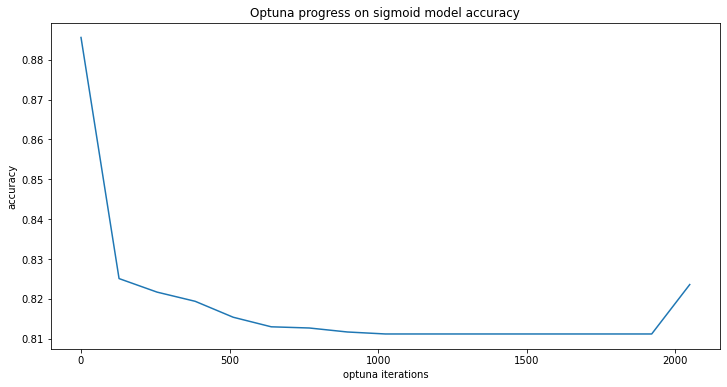

base-model accuracy:0.8879
2048-optuna-iterations-model accuracy:0.8036


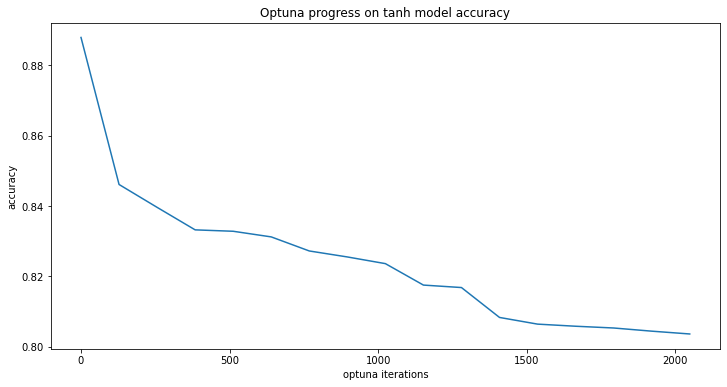

base-model accuracy:0.8892
2048-optuna-iterations-model accuracy:0.8348


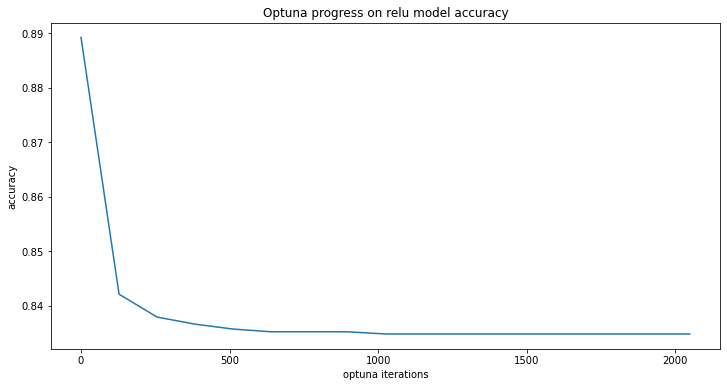

base-model accuracy:0.8866
2048-optuna-iterations-model accuracy:0.7946


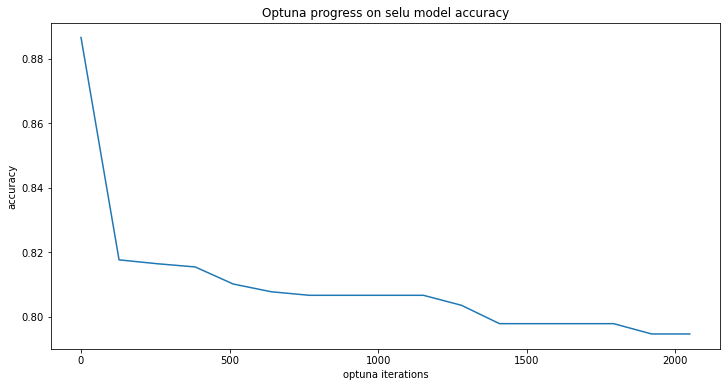

base-model accuracy:0.881
2048-optuna-iterations-model accuracy:0.8057


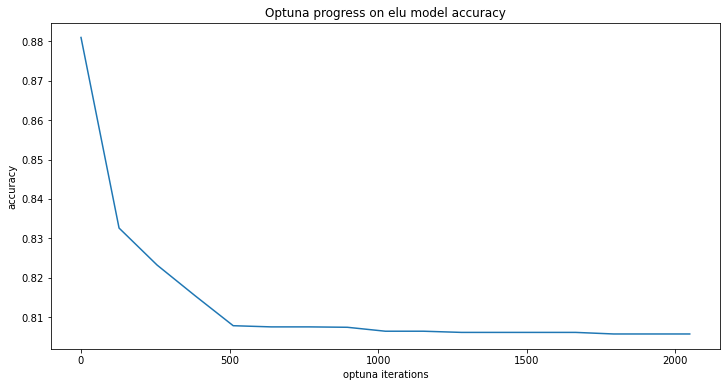

base-model accuracy:0.8576
2048-optuna-iterations-model accuracy:0.8185


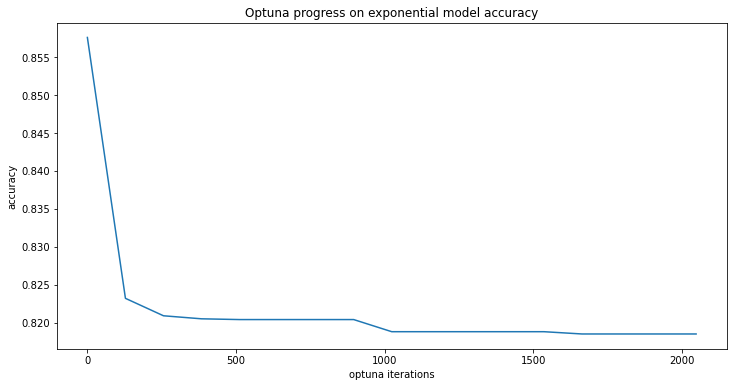

base-model accuracy:0.885
2048-optuna-iterations-model accuracy:0.8244


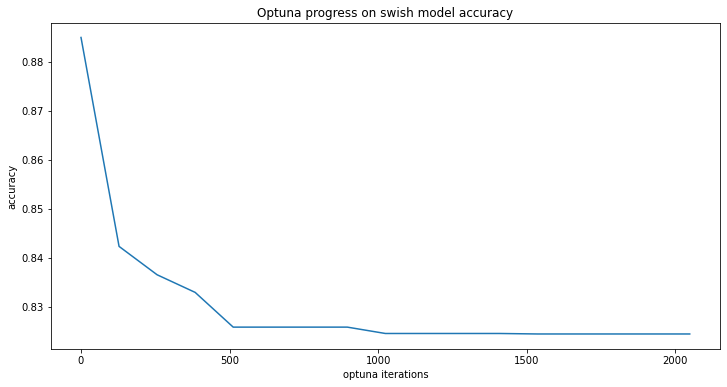

In [3]:


for function, initializer in DEEP_ACTIVATION.items():
    scores_list = []
    checkpoints = [0]
    s = load_object(SCORES_PATH+"/scores_best_"+function)
    scores_list.append(s.accuracy)
    for i in range(N_CHECKPOINTS):
        n = int(N_TRIALS/N_CHECKPOINTS*(i+1))
        # s = load_object(SCORES_PATH+"/scores_best_"+function+"_attack_"+str(n))
        s = load_object(SCORES_PATH+"/scores_best_"+function+"_attack_"+str(n))
        scores_list.append(s.accuracy)
        checkpoints.append(n)
    print(f"base-model accuracy:{scores_list[0]}\n2048-optuna-iterations-model accuracy:{scores_list[-1]}")

    plt.plot(checkpoints, scores_list, label = "line 1")
    plt.title('Optuna progress on '+function+' model accuracy')
    plt.xlabel('optuna iterations')
    plt.ylabel('accuracy')
    plt.show()

#### Best Attacks

index=7275 value=0.8850401639938354


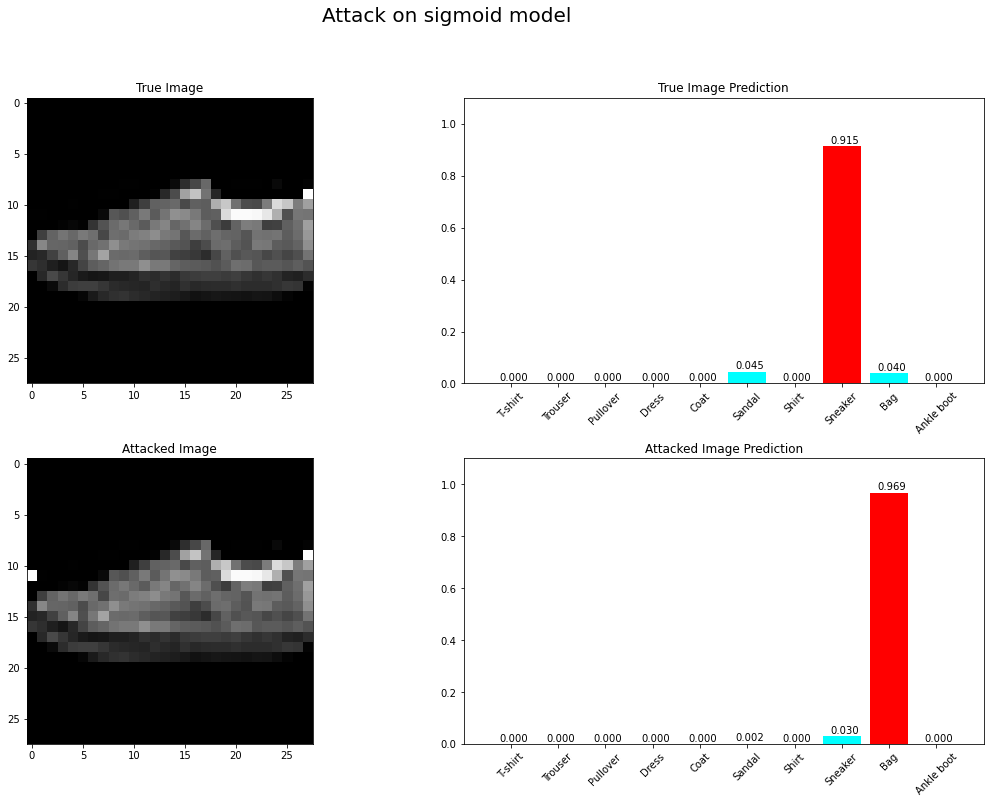

index=5158 value=0.8980278968811035


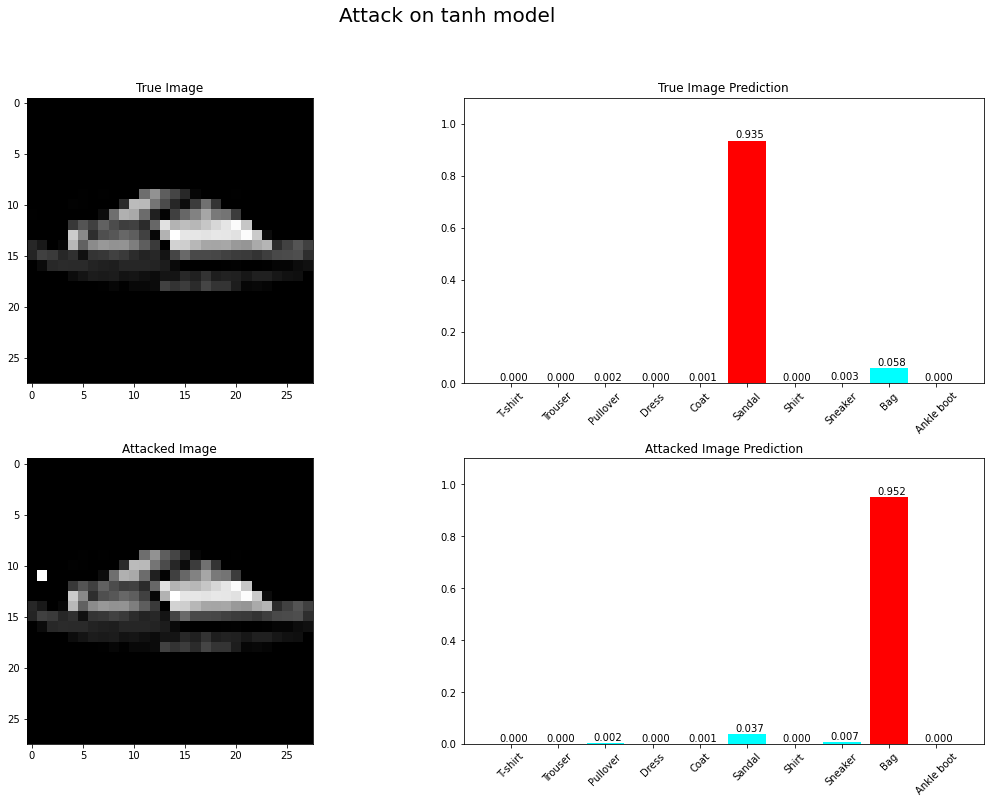

index=1587 value=0.9099850654602051


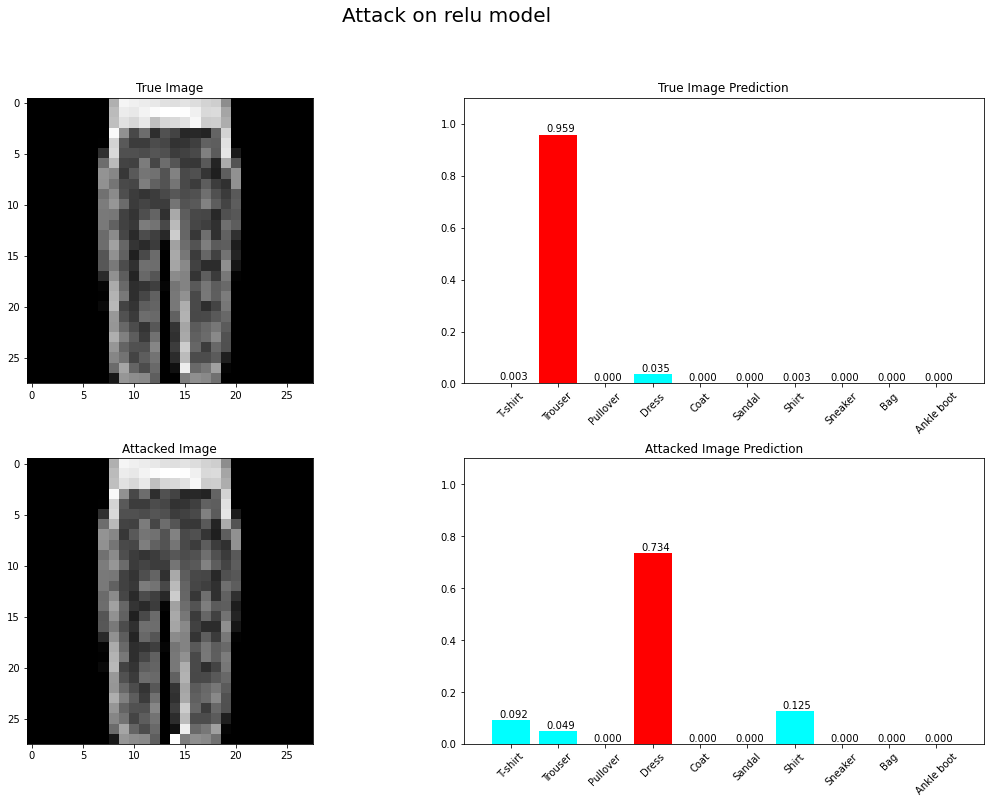

index=5743 value=0.9692894220352173


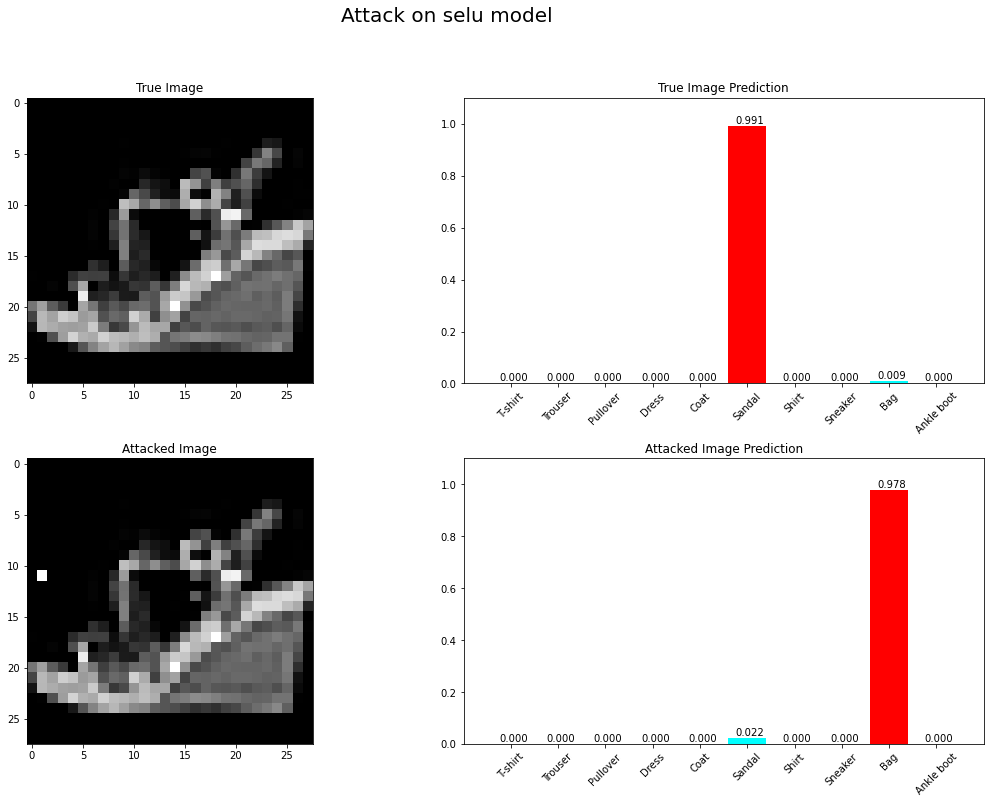

index=1894 value=0.9107810258865356


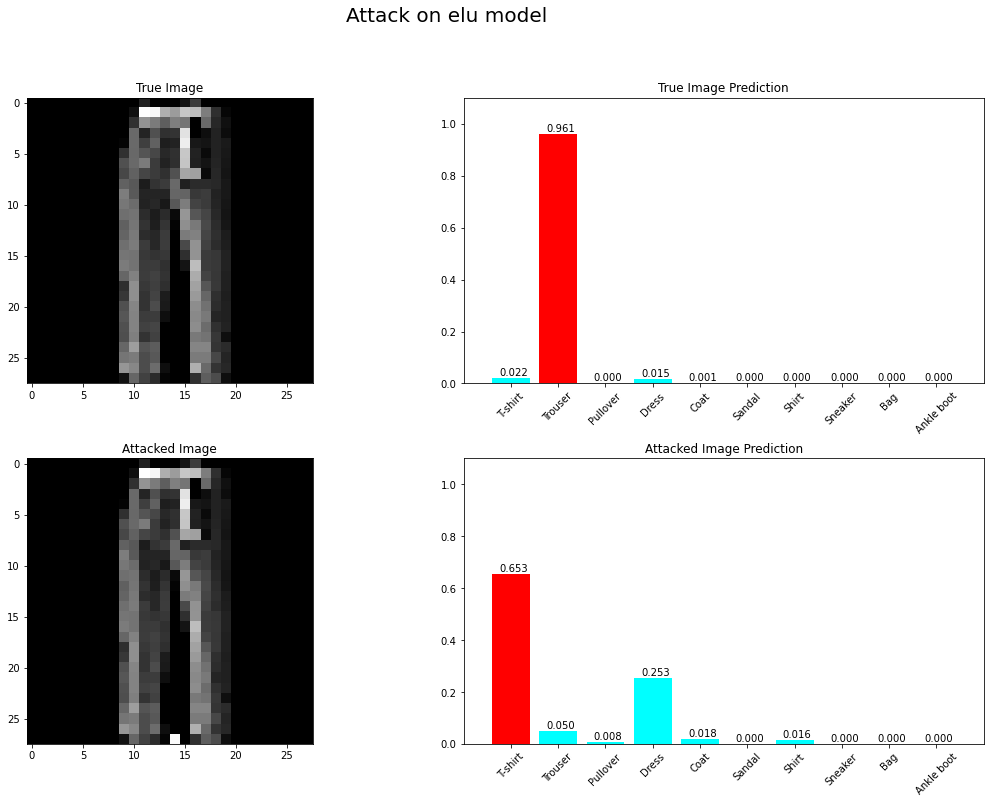

index=8021 value=0.6183361411094666


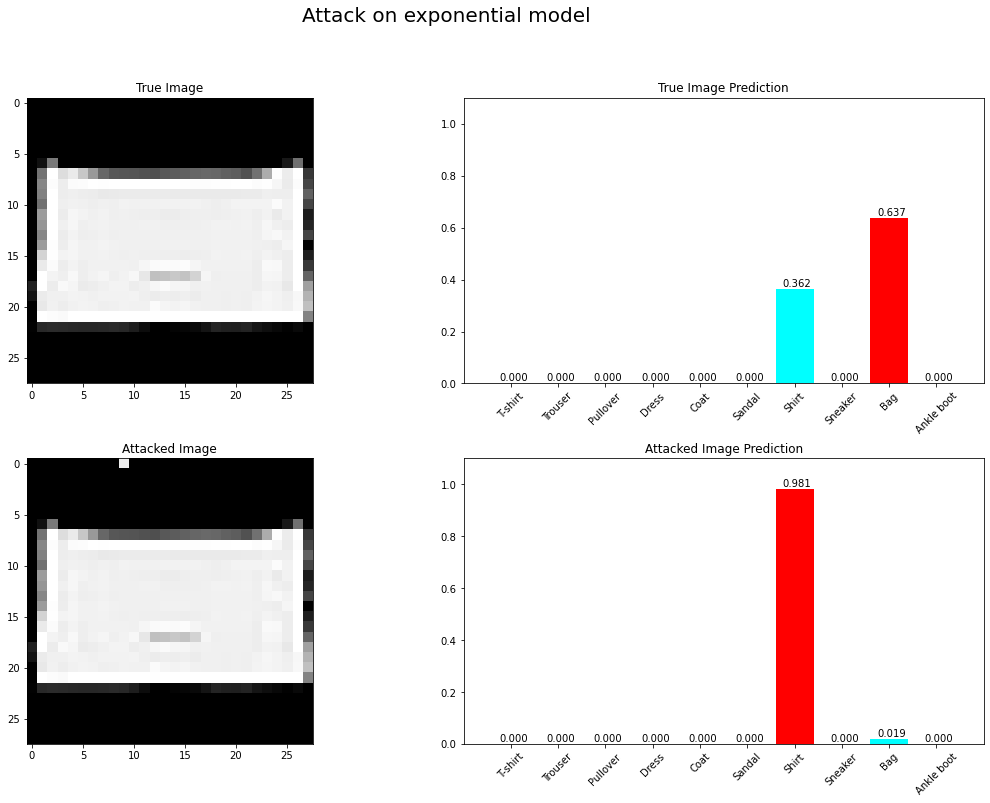

index=5750 value=0.8017588257789612


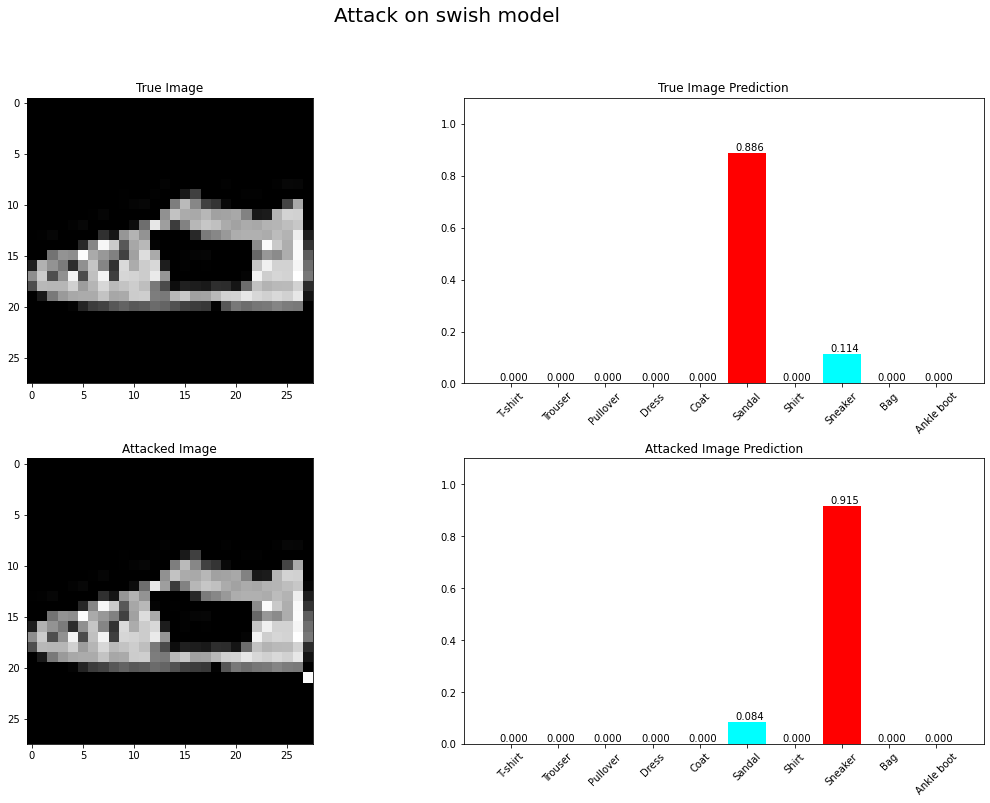

In [5]:
for function, initializer in DEEP_ACTIVATION.items():
    m1 = load_object(SCORES_PATH+"/scores_best_"+function)
    m2 = load_object(SCORES_PATH+"/scores_best_"+function+"_attack_2048")
    m = load_model(MODELS_PATH+"/best_"+function+".h5")
    best_attack = 0
    maximum = 0
    for i in range (len(m1.y_true)): # per ogni immagine
        j = np.nonzero(m1.y_true[i])[0][0] # predizione vera
        k = abs(m1.y_pred[i][j] - m2.y_pred[i][j])
        if k >= maximum:
            maximum = k
            best_attack = i

    print(f"index={best_attack} value={maximum}")
    plot_attack(m1.x_test[best_attack], m2.x_test[best_attack], m, function)

## Conclusions

TODO
Given the results we can say that, under all the hypothesis made for the experiment (dataset, immutable network structure except for changing parameter, hyperparameters, ecc.), comparing the considered measures, the robustness of  hidden activation function is shown below:
...